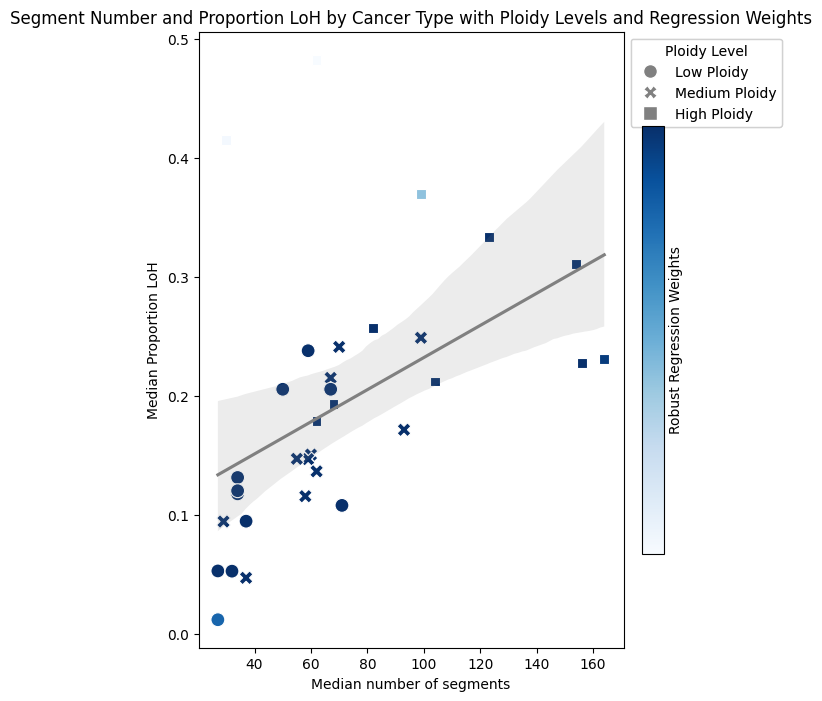

In [5]:
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patches as mpatches
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize

# Load the updated data file
file_path = 'dataall.xlsx'
data = pd.read_excel(file_path)

# Extracting the segment number for each type from the last two columns
segment_numbers = data.iloc[:, -1]
cancer_types = data.iloc[:, -2]

# Creating a DataFrame with cancer types and their corresponding segment numbers
segment_data = pd.DataFrame({
    'cancer_type': cancer_types,
    'Segment Number': segment_numbers
})

# Calculating the median proportion LoH and median ploidy for each cancer type
median_prop_loh = data.groupby('cancer_type')['propLOH'].median()
median_ploidy = data.groupby('cancer_type')['ploidy'].median()

# Merging the segment data with median values
merged_data = segment_data.merge(median_prop_loh, on='cancer_type').merge(median_ploidy, on='cancer_type')

# Preparing data for robust regression
X = merged_data['Segment Number']
y = merged_data['propLOH']
X = sm.add_constant(X)  # Adding a constant for the intercept

# Performing robust regression
robust_regression_model = sm.RLM(y, X).fit()

# Adding robust regression weights to the DataFrame
merged_data['Robust Regression Weights'] = robust_regression_model.weights

# Normalizing the weights to use in color mapping
weights_normalized = (merged_data['Robust Regression Weights'] - merged_data['Robust Regression Weights'].min()) / \
                     (merged_data['Robust Regression Weights'].max() - merged_data['Robust Regression Weights'].min())

# Binning the ploidy into three levels for circle size
ploidy_bins = pd.qcut(merged_data['ploidy'], 3, labels=['Low', 'Medium', 'High'])

# Adjusting the legend to meet the specified requirements

# Plotting with the corrected data
plt.figure(figsize=(6, 8))

# Scatter plot with different circle sizes and shapes for median ploidy levels and gradient colors for regression weights
scatter = sns.scatterplot(data=merged_data, x='Segment Number', y='propLOH',
                          style=ploidy_bins, hue=weights_normalized, palette='Blues', s=100)

# Adding regression line with confidence interval
sns.regplot(x='Segment Number', y='propLOH', data=merged_data,
            scatter=False, color='grey', ci=95)

plt.xlabel('Median number of segments')
plt.ylabel('Median Proportion LoH')
plt.title('Segment Number and Proportion LoH by Cancer Type with Ploidy Levels and Regression Weights')

# Creating custom legend entries for ploidy levels
legend_elements = [plt.Line2D([0], [0], marker='o', color='w', label='Low Ploidy',
                              markerfacecolor='grey', markersize=10),
                   plt.Line2D([0], [0], marker='X', color='w', label='Medium Ploidy',
                              markerfacecolor='grey', markersize=10),
                   plt.Line2D([0], [0], marker='s', color='w', label='High Ploidy',
                              markerfacecolor='grey', markersize=10)]

# Creating the legend for ploidy levels, and placing it above the colorbar legend
upper_legend = plt.legend(handles=legend_elements, title='Ploidy Level', loc='upper left', bbox_to_anchor=(1, 1))

# Create colorbar for the regression weights
sm = ScalarMappable(norm=Normalize(vmin=merged_data['Robust Regression Weights'].min(), vmax=merged_data['Robust Regression Weights'].max()), cmap='Blues')
sm.set_array([])
colorbar = plt.colorbar(sm, ax=plt.gca(), fraction=0.046, pad=0.04)
colorbar.set_label('Robust Regression Weights')
colorbar.set_ticks([])  # Removing the numbers from the colorbar

# Adding the upper legend back after creating the colorbar (which removes it)
plt.gca().add_artist(upper_legend)

plt.show()


<Figure size 2000x600 with 0 Axes>

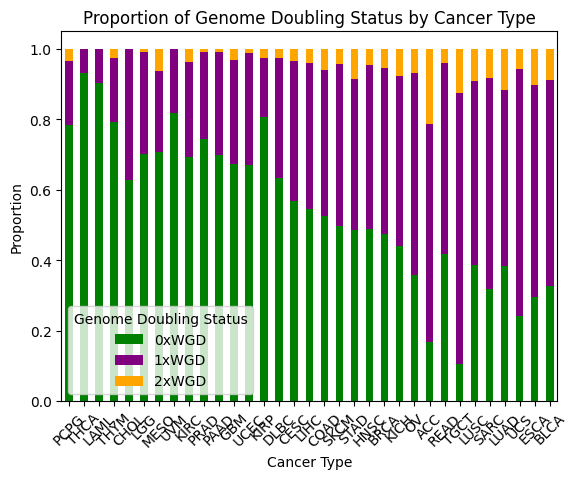

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# Loading the updated data
updated_data_path = 'dataall.xlsx'
data = pd.read_excel(updated_data_path)


# Revising the principle for defining genome doubling status
# New conditions according to the revised principle
conditions = [
    (data['GDx1'] == 1) & (data['GDx2'] == 0),  # 1xWGD
    (data['GDx1'] == 1) & (data['GDx2'] == 1),  # 2xWGD
    (data['GDx1'] == 0) & (data['GDx2'] == 0)  # 0xWGD
]
choices = ['1xWGD', '2xWGD', '0xWGD']
data['Genome Doubling Status'] = np.select(conditions, choices, default=np.nan)


# Calculating the proportion of each genome doubling status within each tumor type
proportions = data.groupby('cancer_type')['Genome Doubling Status'].value_counts(normalize=True).unstack().fillna(0)

# Calculating median ploidies for each cancer type
median_ploidies = data.groupby('cancer_type')['ploidy'].median().sort_values()

# Sorting the proportions according to the median ploidies
sorted_proportions = proportions.loc[median_ploidies.index]

# Plotting the histogram of the proportions
plt.figure(figsize=(20, 6))
sorted_proportions.plot(kind='bar', stacked=True, color={'0xWGD': 'green', '1xWGD': 'purple', '2xWGD': 'orange'})
plt.xlabel('Cancer Type')
plt.ylabel('Proportion')
plt.title('Proportion of Genome Doubling Status by Cancer Type')
plt.legend(title='Genome Doubling Status')
plt.xticks(rotation=45)
plt.show()


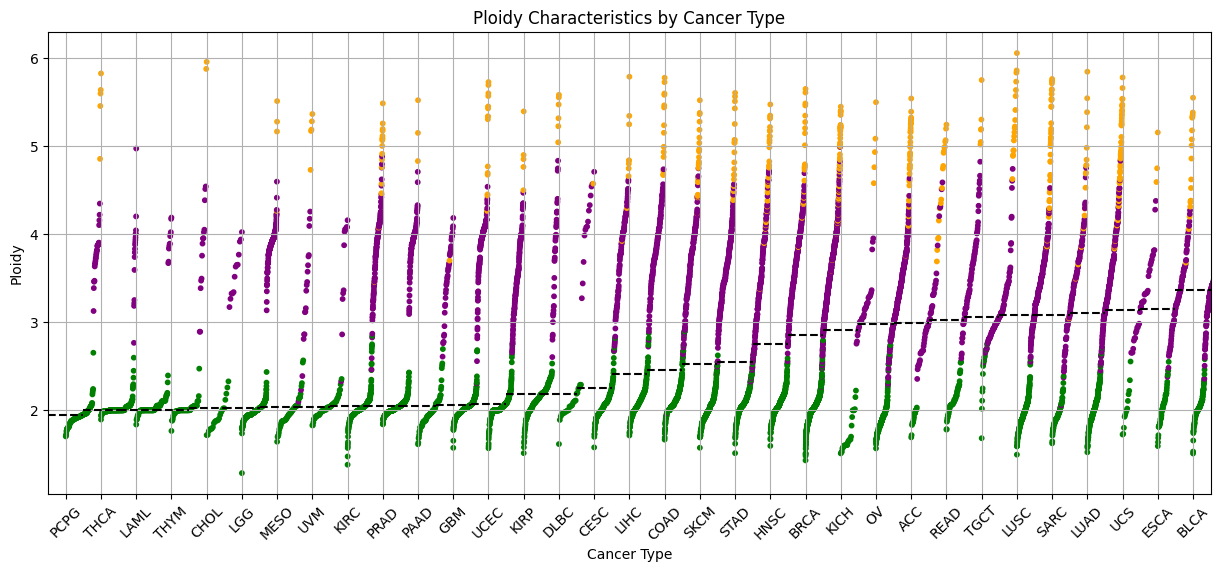

In [13]:
# Revising the plot to rank ploidy values within each cancer type from lower to higher

plt.figure(figsize=(15, 6))

# Step size for x-axis within each cancer type segment
x_step = 0.01

for i, cancer_type in enumerate(median_ploidies.index):
    # Extracting and sorting ploidy data for each cancer type from lower to higher
    sorted_ploidy_data = data[data['cancer_type'] == cancer_type].sort_values(by='ploidy')['ploidy']

    # Generating x-values within each cancer type segment
    x_values = np.linspace(i, i + 1, len(sorted_ploidy_data))

    # Plotting each sample as a small dot
    plt.scatter(x_values, sorted_ploidy_data, c=data[data['cancer_type'] == cancer_type].sort_values(by='ploidy')['Genome Doubling Status'].map({'0xWGD': 'green', '1xWGD': 'purple', '2xWGD': 'orange'}), s=10)

    # Plotting a horizontal line to indicate the median ploidy for each cancer type
    plt.axhline(y=median_ploidies[cancer_type], xmin=i/len(median_ploidies.index), xmax=(i+1)/len(median_ploidies.index), color='black', linestyle='--')

plt.xticks(ticks=np.arange(len(median_ploidies.index)), labels=median_ploidies.index, rotation=45)
plt.xlim(-0.5, len(median_ploidies.index) - 0.5)
plt.xlabel('Cancer Type')
plt.ylabel('Ploidy')
plt.title('Ploidy Characteristics by Cancer Type')
plt.grid(True)
plt.show()


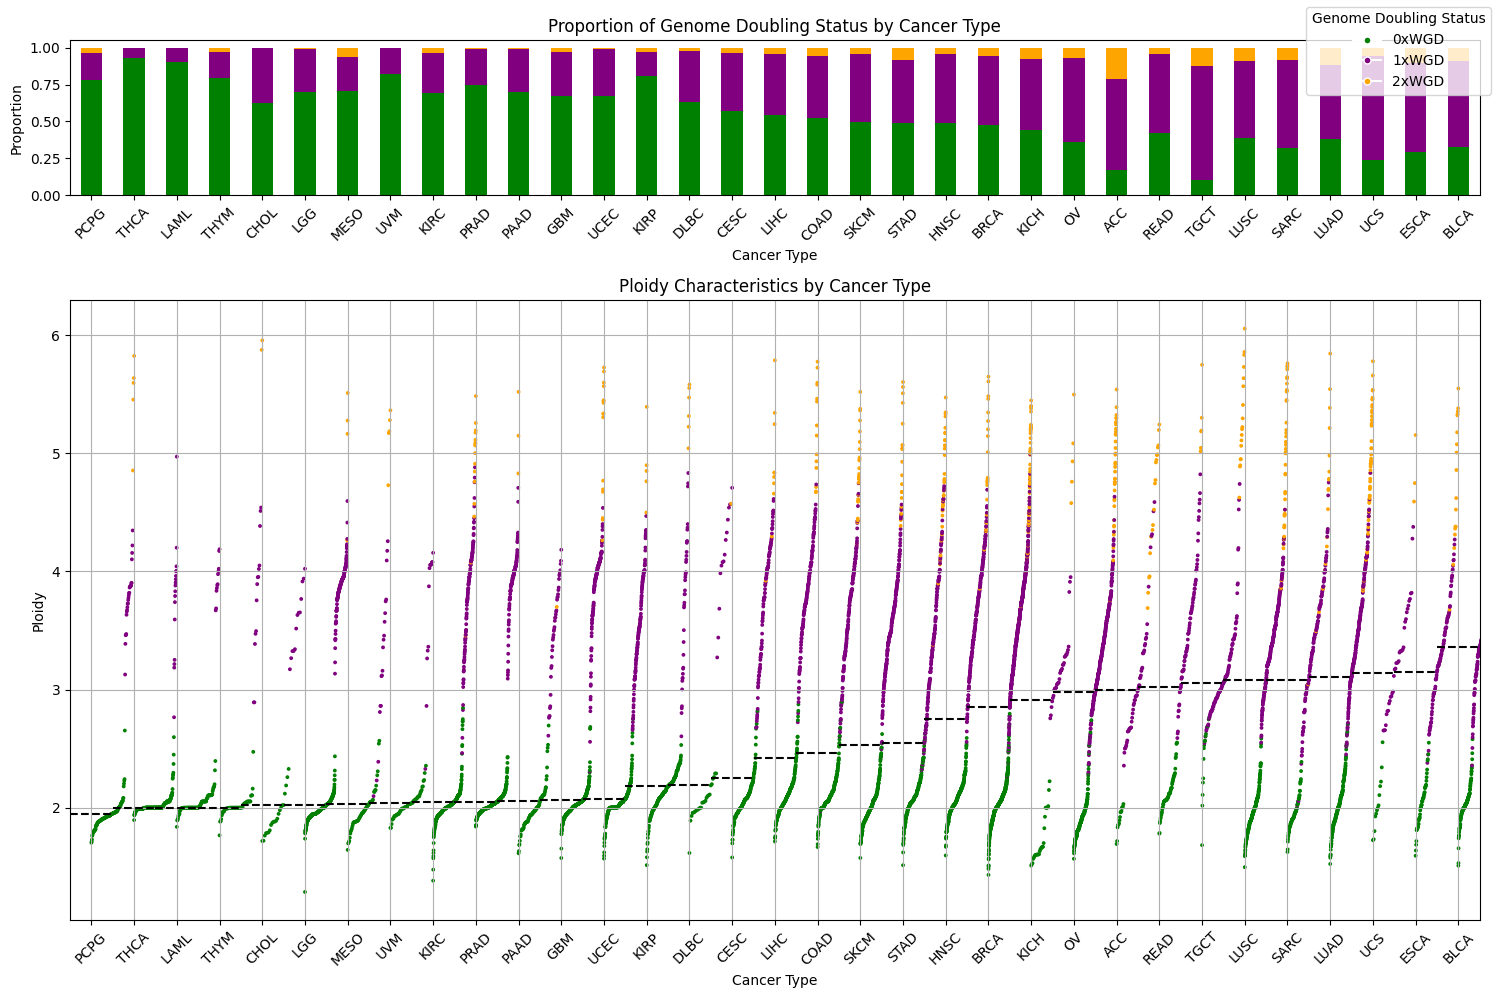

In [19]:


fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10), gridspec_kw={'height_ratios': [1, 4]})

# Plotting the histogram of the proportions
sorted_proportions.plot(kind='bar', stacked=True, color={'0xWGD': 'green', '1xWGD': 'purple', '2xWGD': 'orange'}, ax=ax1)
ax1.set_xlabel('Cancer Type')
ax1.set_ylabel('Proportion')
ax1.set_title('Proportion of Genome Doubling Status by Cancer Type')
ax1.tick_params(axis='x', rotation=45)
ax1.get_legend().remove()  # Remove the legend from the top plot

# Plotting the ploidy characteristics with smaller dots
for i, cancer_type in enumerate(median_ploidies.index):
    sorted_ploidy_data = data[data['cancer_type'] == cancer_type].sort_values(by='ploidy')['ploidy']
    x_values = np.linspace(i, i + 1, len(sorted_ploidy_data))
    ax2.scatter(x_values, sorted_ploidy_data, c=data[data['cancer_type'] == cancer_type].sort_values(by='ploidy')['Genome Doubling Status'].map({'0xWGD': 'green', '1xWGD': 'purple', '2xWGD': 'orange'}), s=3)
    ax2.axhline(y=median_ploidies[cancer_type], xmin=i/len(median_ploidies.index), xmax=(i+1)/len(median_ploidies.index), color='black', linestyle='--')

ax2.set_xticks(np.arange(len(median_ploidies.index)))
ax2.set_xticklabels(median_ploidies.index, rotation=45)
ax2.set_xlim(-0.5, len(median_ploidies.index) - 0.5)
ax2.set_xlabel('Cancer Type')
ax2.set_ylabel('Ploidy')
ax2.set_title('Ploidy Characteristics by Cancer Type')
ax2.grid(True)

# Creating a shared legend for the genome doubling status
legend_elements = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='green', markersize=5, label='0xWGD'),
                   plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='purple', markersize=5, label='1xWGD'),
                   plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='orange', markersize=5, label='2xWGD')]
fig.legend(handles=legend_elements, title='Genome Doubling Status', loc='upper right')

plt.tight_layout()
plt.show()
